#Transfer Learning



### Kort sammanfattning av Rethinking the Inception Architecture for Computer Vision
Arkitekturen är väldigt viktig för att inte beräkningmängden/inlärningsförmågan och generaliseringsförmågan skall bli dålig. I denna artkel beskrivs design principer och optimeringsideer. 

I designprinciperna så följer dessa: 
1. undvik flaskhalsar, dvs för snabb komprimering (minskning av noder i lager)
2. högre dimensionalitet (noder/lager) gär att nätverket läåttare kan lösa och dela upp egenskaper som behövs för output (klassificering)
3. Spatial aggregering kan uppnås genom konvulution i mindre dimensioner vilket gör att input storlek kan minskas
4. Balans mellan djup och bredd i nätverket. 

Författarna påpekar också att assymetri kan vara en viktig del konvulutionen, speciellt i senare lager. Vidare föreslår dem att LSR (Label smooth regularization) för att ta hänsyn till sanningen (sant vs falsk klassificering vid supevised learning) inte ska tolkas "bokstavligt" utan innehålla en faktor som också avspeglar distributionen. Detta kan minska overfitting och öka generaliseringsförmågan. 

In [1]:
#import tensorflow_datasets as tfds
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 



In [2]:
#from tensorflow.keras.applications import InceptionV3

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

base_model = tf.keras.applications.InceptionV3(input_shape=(120,120,3), include_top=False, weights='imagenet')

# model=keras.applications.InceptionV3(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

# gör så att base model inte är tränbar - kan fixa detta senare

for layer in base_model.layers:
    layer.trainable=False


#base_model.summary()



In [3]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
# Skapa ett tillägg (efterbearbetning) till Inception-v3 modellen med ett flatten (input), mellanlager och output

# Inspirerat från Medium.com

def CNN_model(learning_rate=0.001, drop_rate=0.3):

    print(drop_rate)
    # default learning rate in Adam, Adam is an optimizor for learning rate, 
    # adam = Adam(learning_rate=learning_rate)

    # model = Sequential(name="CNN_model")
    
    # använd Inception-v3 modellen som input i tränbara modellen (dvs dess output blir input)
    model = tf.keras.layers.Flatten()(base_model.output)
    # lägg till ett dense "hidden" layer
    model = tf.keras.layers.Dense(1024, activation='relu')(model)
    # lägg till dropouts
    model= tf.keras.layers.Dropout(drop_rate)(model)
    # lägg till output layer (node)
    model = tf.keras.layers.Dense(1, activation='sigmoid')(model)

    # gör så att input går till Inception-v3 modellen
    model= tf.keras.Model(base_model.input, model)

    

    model.compile(loss="binary_crossentropy", 
                  optimizer=RMSprop(learning_rate=learning_rate), 
                  metrics=["acc"]
    )

    return model

model2 = CNN_model(.0001, .5)


0.5


In [4]:
import pickle

def load_data(pathfile):
    f = open(pathfile, 'rb')
    obj1, obj2 = pickle.load(f)
    f.close()
    arr = np.random.choice(np.arange(0, len(obj1)), size=len(obj1), replace=False)
    obj3=[obj1[i] for i in arr]
    obj4=[obj2[i] for i in arr]
    return [obj3, obj4]

X_train, y_train=load_data("experiment_small_data/train/train.dat")
X_test, y_test=load_data("experiment_small_data/test/test.dat")
X_train2, y_train2 =load_data("experiment_small_data/train/train2.dat")
X_val, y_val=load_data("experiment_small_data/val/validate.dat")

def toOneHot(data):
    code=[]
    for x in data:
        if x=='Dog':
            code.append(0)
        else:
            code.append(1)
    return code

# Y_xxx -> y_train, y_test, y_train2, y_val (experimental small)
# y_xxx -> y_train_tiny, y_test_tiny, y_train2_tiny, y_val_tiny

y_train=np.array(toOneHot(y_train))
y_test=np.array(toOneHot(y_test))
y_train2=np.array(toOneHot(y_train2))
y_val=np.array(toOneHot(y_val))

In [5]:
import cv2

size_x=120
size_y=120

def scale_images(image_arr):
    #output_arr = []
    #for image in image_arr:
        # output_arr.append(cv2.resize(image,(size_x, size_y)))
    output_arr = np.array([cv2.resize(image, (size_x, size_y)) for image in image_arr])
    return output_arr


X_train_scaled = scale_images(X_train)
X_train2_scaled = scale_images(X_train2)
X_test_scaled = scale_images(X_test)
X_val_scaled = scale_images(X_val)


X_train_scaled = X_train_scaled/255
X_train2_scaled = X_train2_scaled/255
X_test_scaled = X_test_scaled/255
X_val_scaled = X_val_scaled/255

In [6]:
y_train

array([1, 0, 0, ..., 0, 1, 1])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# help(ImageDataGenerator())

train_image_generator = ImageDataGenerator(
    rotation_range=35, # 35 grader rotation 
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,# tillåt flip  (spegelvänd bild)
    vertical_flip=False, 
    height_shift_range=0.1,
    width_shift_range=0.1,
)
# don't augment test data and validation data as we want to test on original data
# we just instantiate an ImageDataGenerator without augmentation
test_image_generator = ImageDataGenerator()

# batch size 32 for mini-batch gradient descent - gives stocasticity (avoid local minima)
# flow used for regenerating images after it has been exhausted
# this beacause we will train in many epochs
train_val_generator = train_image_generator.flow(
    X_train2_scaled, np.array(y_train2), batch_size=32
)

# batch size 32 for mini-batch gradient descent 
train_generator = train_image_generator.flow(
    X_train_scaled, np.array(y_train), batch_size=32
)

# train_generator[0][0].shape -> a 32 images batch

val_generator = test_image_generator.flow(X_val_scaled, np.array(y_val), batch_size=32)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping


steps_per_epochs = len(X_train2_scaled)/32
validation_steps = len(X_val_scaled)/32

early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=0.00001)

# några issues med modellen - misstänker att något är fel med klassificeringen då den 
# inte ger helt korrekta svar och pendlar väl mycket i ACC och LOSS 

# model2.fit(
#     train_generator,
#     steps_per_epoch=int(steps_per_epochs),
#     epochs=200,
#     callbacks=[early_stopper],
#     validation_data=val_generator,
#     validation_steps=int(validation_steps),
#     )

model2.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    callbacks=[early_stopper],
    validation_split=1 / 5,
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 665ms/step - acc: 0.7403 - loss: 3.1689 - val_acc: 0.8450 - val_loss: 0.6413
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 613ms/step - acc: 0.9002 - loss: 0.4066 - val_acc: 0.8675 - val_loss: 0.6632
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 616ms/step - acc: 0.9269 - loss: 0.2940 - val_acc: 0.9075 - val_loss: 0.4016
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 596ms/step - acc: 0.9341 - loss: 0.2862 - val_acc: 0.9075 - val_loss: 0.4446
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 614ms/step - acc: 0.9392 - loss: 0.1888 - val_acc: 0.9050 - val_loss: 0.3853
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 610ms/step - acc: 0.9493 - loss: 0.2065 - val_acc: 0.9200 - val_loss: 0.3852
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 879ms/step - acc: 0.9436 - loss: 0.1931 - val_acc: 0.9275 - val_loss: 0.3704
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 704ms/step - acc: 0.9678 - loss: 0.0992 - val_acc: 0.8950 - val_loss: 0.5473
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3

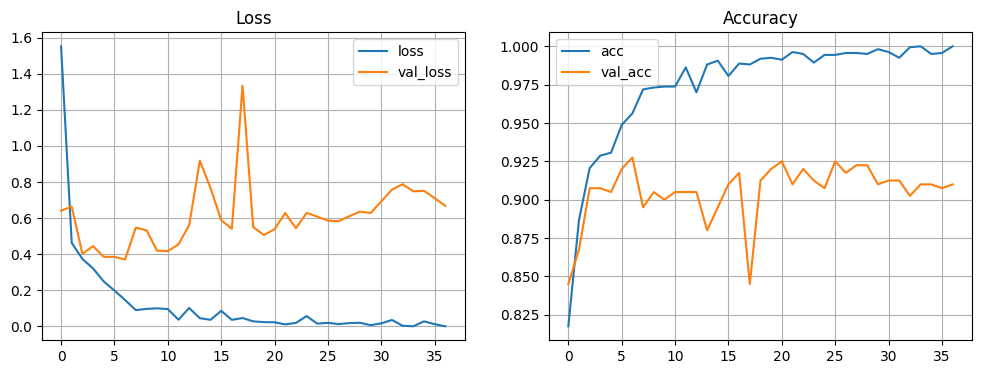

In [9]:
metrics = pd.DataFrame(model2.history.history)
metrics.head()

def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)


plot_metrics(metrics)



16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       250
           1       0.99      0.61      0.75       250

    accuracy                           0.80       500
   macro avg       0.85      0.80      0.79       500
weighted avg       0.85      0.80      0.79       500



(array([0, 1]), [Text(0, 0, 'Dog'), Text(1, 0, 'Cat')])

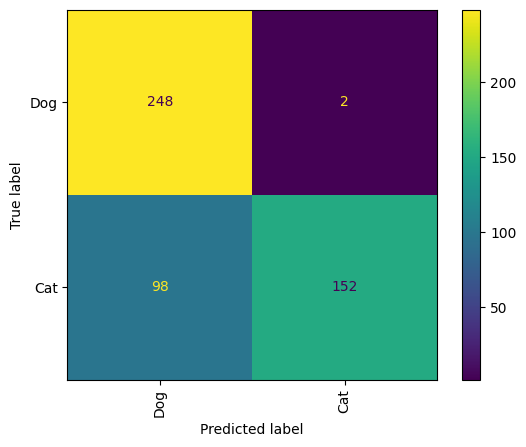

In [21]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model2.predict(X_test_scaled)
y_pred = y_pred.astype(int)

#y_pred = np.argmax(y_pred, axis = 1)

labels=["Dog","Cat"]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
plt.xticks(rotation = 90)


In [19]:
y_pred.astype(int)

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
    

In [12]:
y_test

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,